In [2]:
!pip install cupy-cuda112

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80.8 MB 1.1 MB/s 


In [3]:
# !nvidia-smi

In [4]:
# !python -m pip install -U setuptools pip

In [5]:
# import cupy as cp

In [6]:
from IPython.display import Image as Img
import matplotlib.pyplot as plt
from timeit import default_timer
from tqdm import tqdm
from PIL import Image
import numpy as np
import cupy as cp
import glob
import os

## [High performance with <u><i><strong>CUDA</strong></i></u>](https://cupy.chainer.org/)
<u><i><strong>CuPy</strong></i></u> is an open-source matrix library accelerated with <u><i><strong>NVIDIA CUDA</strong></i></u>. <u><i><strong>CuPy</strong></i></u> provides GPU accelerated computing with Python. CuPy uses CUDA-related libraries including <u><i><strong>cuBLAS</strong></i></u>, <u><i><strong>cuDNN</strong></i></u>, <u><i><strong>cuRand</strong></i></u>, <u><i><strong>cuSolver</strong></i></u>, <u><i><strong>cuSPARSE</strong></i></u>, <u><i><strong>cuFFT</strong></i></u> and <u><i><strong>NCCL</strong></i></u> to make full use of the <u><i><strong>GPU</strong></i></u> architecture.
The figure shows <u><i><strong>CuPy</strong></i></u> speedup over NumPy. Most of them perform well on a <u><i><strong>GPU</strong></i></u> using CuPy out of the box. <u><i><strong>CuPy</strong></i></u> speeds up some operations more than 100X. You can read original benchmark article in [Single-<u><i><strong>GPU</strong></i></u> <u><i><strong>CuPy</strong></i></u> Speedups (RAPIDS AI)](https://medium.com/rapids-ai/single-gpu-cupy-speedups-ea99cbbb0cbb).

![CuPy speedup over NumPy](CuPy_Performance.png)

## [Highly compatible with <u><i><strong>NumPy</strong></i></u>](https://cupy.chainer.org/)
<u><i><strong>CuPy</strong></i></u>'s interface is highly compatible with <u><i><strong>NumPy</strong></i></u>; in most cases it can be used as a <strong><i><u>drop-in replacement</u></i></strong>. <i><u>All you need to do</u></i> is just <strong><i><u>replace numpy with cupy</u></i></strong> in your Python code. [Basics of <u><i><strong>CuPy</strong></i></u> (Tutorial)](https://docs-cupy.chainer.org/en/stable/tutorial/basic.html) is usefull to learn first step of <u><i><strong>CuPy</strong></i></u>.
<u><i><strong>CuPy</strong></i></u> supports various methods, indexing, data types, broadcasting and more. [Comparison Table (Reference Manual)](https://docs-cupy.chainer.org/en/stable/reference/comparison.html) shows a list of NumPy / <u><i><strong>SciPy</strong></i></u> APIs and its corresponding <u><i><strong>CuPy</strong></i></u> implementations.

In [7]:
x = cp.arange(6).reshape(2, 3).astype('f')
print("x =\n", x)

sum_result = x.sum(axis=1)
print("\nsum = ",sum_result)

x =
 [[0. 1. 2.]
 [3. 4. 5.]]

sum =  [ 3. 12.]


## [Easy to write a custom kernel](https://cupy.chainer.org/)
You can easily make a custom <u><i><strong>CUDA</strong></i></u> kernel if you want to make your code run faster, requiring only a small code snippet of <u><i><strong>C++</strong></i></u>. <u><i><strong>CuPy</strong></i></u> automatically wraps and compiles it to make a <u><i><strong>CUDA</strong></i></u> binary. Compiled binaries are cached and reused in subsequent runs. Please read [User-Defined Kernels (Tutorial)](https://docs-cupy.chainer.org/en/latest/tutorial/kernel.html).
And, you can also use raw <u><i><strong>CUDA</strong></i></u> kernel via [Raw modules (Tutorial)](https://docs-cupy.chainer.org/en/latest/tutorial/kernel.html#raw-modules).


In [8]:
x=cp.arange(6, dtype='f').reshape(2, 3)
y=cp.arange(3, dtype='f')
kernel=cp.ElementwiseKernel(
    'float32 x,float32 y','float32 z',
        '''if(x-2>y){
        z=x*y;
        }else{
        z=x+y;
        }''',
    'my_kernel')

print("Input x = \n", x)
print("\nInput y = \n", y)

result = kernel(x, y)

print("\nresult of the kernel =\n", result)

Input x = 
 [[0. 1. 2.]
 [3. 4. 5.]]

Input y = 
 [0. 1. 2.]

result of the kernel =
 [[ 0.  2.  4.]
 [ 0.  4. 10.]]


## Task 10. Saxpy

By using <u><i><strong>CuPy</strong></i></u>, implement SAXPY function. The function is described in the picture.

![saxpy](saxpy.jpg)

CuPy’s interface is a mirror of Numpy, it can be used as a direct replacement to leverage the GPU resources which can speed np already optimized numpy implementation. in cause of NVIDIA arc GPUs not available cupy auto switches to basic numpy.

for example with cp.cuda.Device(0) transfers the data to GPU 0 and similarly it can be distributed across the arc including CPU

In [9]:
@cp.fuse()
def cp_saxpy_func(x, y, alpha):
    return x * alpha + y

def np_saxpy_func(x, y, alpha):
    return x * alpha + y

In [10]:
np_times = []
cp_times = []

sizes = np.logspace(1, 7)

for s in sizes:
    start = default_timer()
    x, y = cp.random.rand(int(s)), cp.random.rand(int(s))
    alpha = cp.random.rand()
    cp_saxpy_func(x.get(), y.get(), alpha.get()).sum()
    cp_times.append(default_timer() - start)

for s in sizes:
    start = default_timer()
    x, y = np.random.rand(int(s)), np.random.rand(int(s))
    alpha = np.random.rand()
    np_saxpy_func(x, y, alpha).sum()
    np_times.append(default_timer() - start)

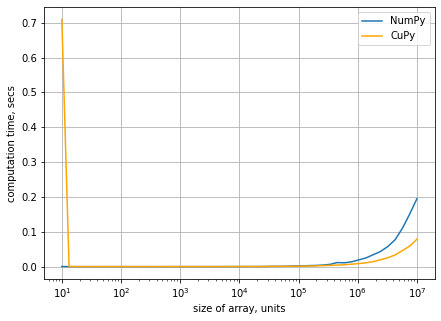

In [11]:
plt.figure(figsize=(7, 5))

plt.semilogx(sizes, np_times, label='NumPy')

plt.semilogx(sizes, cp_times, color='orange', label='CuPy')

plt.xlabel('size of array, units')
plt.ylabel('computation time, secs')
plt.legend()
plt.grid()
plt.show()

## Task 11. CuPy-based Bifurcation map

By using <u><i><strong>CuPy</strong></i></u>, reimplement bifurcation map (Task 1).

In [19]:
NUM_OF_STEPS = 100000
# INITIAL_STATE = 0.1
M = 100
N = 10000

In [20]:
cp_r_list = cp.linspace(0, 1, M)

In [21]:
@cp.fuse()
def cp_get_next_step(r, x):
    return r * x * (1. - x)

@cp.fuse()
def cp_get_bif_map(num_of_iters):
    # times = []
    data = cp.empty((M, M))

    start = default_timer()
    x = cp.repeat(cp.random.rand(), NUM_OF_STEPS)
    for index, r in enumerate(tqdm(cp_r_list)):
        for i in range(1, x.shape[0]):
            x[i] = cp_get_next_step(r, x[i-1])
        
        data[index] = x[index + N: index + N + M]
          
        # times.append()
        
        if num_of_iters < index:
          break

    return data, default_timer() - start


In [22]:
np_r_list = np.linspace(0, 1, M)

In [23]:
def np_get_next_step(r, x):
    return r * x * (1. - x)

def np_get_bif_map(num_of_iters):
    # times = []
    data = np.empty((M, M))

    start = default_timer()
    x = np.repeat(np.random.rand(), NUM_OF_STEPS)
    for index, r in enumerate(tqdm(np_r_list)):
        for i in range(1, x.shape[0]):
            x[i] = np_get_next_step(r, x[i-1])
        
        data[index] = x[index + N: index + N + M]

        # times.append()
        
        if num_of_iters < index:
          break
    return data, default_timer() - start

In [24]:
np_times = []
cp_times = []

for its in np.logspace(1, 2, 10):
    _, time = cp_get_bif_map(its)
    cp_times.append(time)

for its in np.logspace(1, 2, 10):
    _, time = np_get_bif_map(its)
    np_times.append(time)

100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


In [26]:
iter_data, _ = cp_get_bif_map(10000) 

100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


In [99]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438492 sha256=3fcf444ce4564b96ad13f7218401bf2d521cf4cda4aaa487373963a28c093e0f
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [100]:
%%writefile mpi_bifurcation.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

step_count = np.power(10, 3)
x_initial_state = 0.1
r_slices = np.power(10 ,2)

r_range = np.linspace(1, 10, r_slices)

def get_next_step(r, x):
    return r * x * (1. - x)

size_per_rank = int(r_slices / size)



if rank == size - 1:
  size_per_rank += r_slices % size
  left_limit, right_limit = rank * size_per_rank, r_slices - 1

else:
  left_limit, right_limit = rank * size_per_rank, (rank + 1) * size_per_rank

iter_data = np.empty([size_per_rank, r_slices])




for i, r in enumerate(r_range[left_limit: right_limit]):
  x = [x_initial_state]
  for _ in range(step_count):
      x.append(get_next_step(r, x[-1]))
      
  iter_data[i] = x[500: 500 + r_slices]

iter_data = comm.gather((iter_data, rank) if size > 1 else iter_data, root=0)

MPI.Finalize()



if rank == 0:
  if size > 1:
    iter_data.sort(key = lambda tup: tup[1])
    iter_data = np.array(iter_data)[:, :-1].squeeze()
    iter_data = np.concatenate(iter_data, axis=0)
  else:
    iter_data = np.array(iter_data).squeeze()
    
  fig, ax = plt.subplots(figsize=(10, 8))

  fig.set_facecolor('red')

  ax.axis([min(r_range), 5, 0, 1 + 0.1])
  ax.set_facecolor('blue')

  ax.set_xlabel('r')
  ax.set_ylabel('population equlibrium')
  l, = ax.plot([], [], '.', color='green')

  t = [r * np.ones(iter_data.shape[0]) for r in r_range]
  
  dir_name = 'gif_pics'
  
  os.system(f'rm -rf {dir_name}')
  os.mkdir(dir_name)

  images = []

  for i, _ in enumerate(t):
      index = str(i).zfill(4)
      imgname = f'{dir_name}/bif_pic_{index}' 
      images.append(imgname)

      ax.scatter(t[:i], iter_data[:i], c='yellow')
      plt.savefig(images[-1])

Writing mpi_bifurcation.py


In [114]:
np.logspace(1, 2, 10).astype(int)

array([ 10,  12,  16,  21,  27,  35,  46,  59,  77, 100])

In [116]:
from time import time
from tqdm import tqdm

mpi_times = []
for i in tqdm(np.logspace(1, 2, 10).astype(int)):
    t = time()
    !mpirun --allow-run-as-root -n {i} python mpi_bifurcation.py
    mpi_times.append((time()-t))

100%|██████████| 10/10 [16:15<00:00, 97.59s/it] 


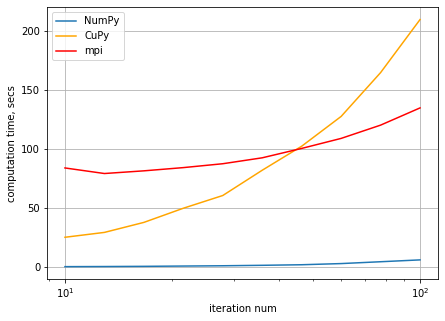

In [117]:
plt.figure(figsize=(7, 5))

plt.semilogx(np.logspace(1, 2, 10), np_times, label='NumPy')

plt.semilogx(np.logspace(1, 2, 10), cp_times, color='orange', label='CuPy')

plt.semilogx(np.logspace(1, 2, 10), mpi_times, color='red', label='mpi')

plt.xlabel('iteration num')
plt.ylabel('computation time, secs')
plt.legend()
plt.grid()
plt.show()

For some reason numpy out performs cupy, it maybe due to colab GPU restrictions, as the plotting is done initially and with parallel mpi im not showing the final plot but the data is ofcource can be outputted from the function. I guess the main point here is to check speed

In [118]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fo

In [119]:
!convert gif_pics/* bif_map.gif

## Task 12. Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram. <strong>[Hint: how to represent the histogram](https://cdn.datamentor.io/wp-content/uploads/2017/11/r-histogram.png)</strong>

<strong >Hint about function $f(x)$ appearance:</strong>
    ![Hint](Hint.png)

In [52]:
@cp.fuse()
def z_func(x):
    return cp.sin(3 * x) - 0.5

@cp.fuse()
def f_func(x):
    z = z_func(x)
    z_squared = cp.power(z, 2)

    return z_squared * (1. + z - 200 * z_squared) * cp.sin(1000000 * (x + 0.5))

In [53]:
x = cp.linspace(0., 1., 10000000)

In [54]:
f_cp_vals = f_func(x)

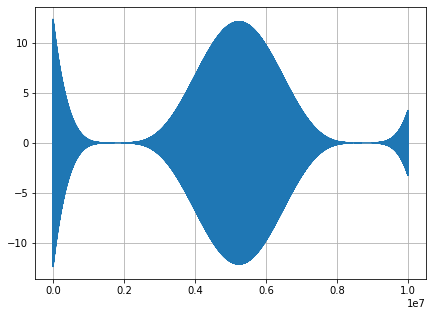

In [55]:
plt.figure(figsize=(7, 5))

plt.plot(f_cp_vals.get())

plt.grid()
plt.show()

In [56]:
f_min, f_max = f_cp_vals.min().get(), f_cp_vals.max().get() 

In [57]:
print('f_min = {:.3f}'.format(f_min))
print('f_max = {:.3f}'.format(f_max))

f_min = -12.373
f_max = 12.369


In [58]:
sigma = 0.1 * (f_max - f_min)

In [59]:
y = cp.arange(f_min, f_max + sigma, sigma)
print(y)

[-1.23730514e+01 -9.89883147e+00 -7.42461150e+00 -4.95039154e+00
 -2.47617157e+00 -1.95160797e-03  2.47226836e+00  4.94648832e+00
  7.42070829e+00  9.89492825e+00  1.23691482e+01]


In [60]:
bins = []

for i in tqdm(range(1, y.shape[0])):
    a, b = y[i-1], y[i]

    is_inside = ((a < f_cp_vals) & (f_cp_vals < b))
    
    bin = cp.sum(is_inside).get()
    bins.append(bin)

100%|██████████| 10/10 [00:01<00:00,  9.65it/s]


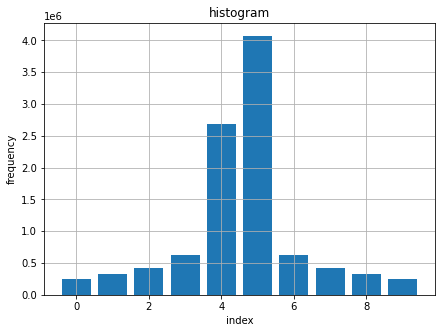

In [61]:
plt.figure(figsize=(7, 5))

plt.bar(range(len(bins)), bins)

plt.title('histogram')
plt.xlabel('index')
plt.ylabel('frequency')

plt.grid()
plt.show()

In [62]:


@cp.fuse()
def z_func(x):
    return cp.sin(3 * x) - 0.5

@cp.fuse()
def f_func(x):
    z = z_func(x)
    z_squared = cp.power(z, 2)

    return z_squared * (1. + z - 200 * z_squared) * cp.sin(1000000 * (x + 0.5))

def cp_get_bins():
  x = cp.linspace(0., 1., 10000000)

  f_cp_vals = f_func(x)
  
  f_min, f_max = f_cp_vals.min().get(), f_cp_vals.max().get() 
  sigma = 0.1 * (f_max - f_min)

  y = cp.arange(f_min, f_max + sigma, sigma)
  
  # bins = []

  start = default_timer()
  for i in range(1, y.shape[0]):
    a, b = y[i-1], y[i]

    is_inside = ((a < f_cp_vals) & (f_cp_vals < b))
    
    bin = cp.sum(is_inside).get()
    # bins.append(bin)
  
  return default_timer() - start

In [63]:
def z_func(x):
    return np.sin(3 * x) - 0.5

def f_func(x):
    z = z_func(x)
    z_squared = np.power(z, 2)

    return z_squared * (1. + z - 200 * z_squared) * np.sin(1000000 * (x + 0.5))

def np_get_bins():
  x = np.linspace(0., 1., 10000000)

  f_cp_vals = f_func(x)
  
  f_min, f_max = f_cp_vals.min(), f_cp_vals.max()
  sigma = 0.1 * (f_max - f_min)

  y = np.arange(f_min, f_max + sigma, sigma)
  
  # bins = []

  start = default_timer()
  for i in range(1, y.shape[0]):
    a, b = y[i-1], y[i]

    is_inside = ((a < f_cp_vals) & (f_cp_vals < b))
    
    bin = np.sum(is_inside)
    # bins.append(bin)

  return default_timer() - start

In [64]:
avg = 0.

for _ in range(10):
  avg += cp_get_bins()

avg /= 10

print(f'CuPy time: {avg:.2f} secs')



avg = 0.

for _ in range(10):
  avg += np_get_bins()

avg /= 10

print(f'NumPy time: {avg:.2f} secs')

CuPy time: 0.08 secs
NumPy time: 0.26 secs


## Task 13. Image blur


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image and 

<strong >Example of a blurred image:</strong>
    ![Blur](blur.jpg)

In [65]:
img_name = '/content/cat.jpg'

In [66]:
np_img = plt.imread(img_name)
cp_img = cp.asarray(plt.imread(img_name))

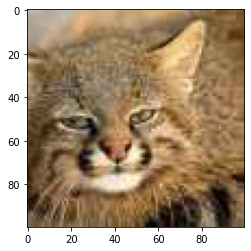

In [67]:
plt.imshow(np_img)

plt.show()

Creating a very simple kernel with same element

In [68]:
def get_np_kernel(size):
    if size % 2 == 0:
        raise ValueError

    return 1 / (size**2) * np.ones((size, size))

def get_cp_kernel(size):
    if size % 2 == 0:
        raise ValueError

    return 1 / (size**2) * cp.ones((size, size))

In [69]:
np_kernel = get_np_kernel(3)
cp_kernel = get_cp_kernel(3)

In [70]:
from scipy.signal import convolve2d as np_conv

In [71]:
%%time
np_blur_img = np.dstack([np_conv(np_img[:, :, i], np_kernel) for i in range(np_img.shape[-1])]).astype(np.uint8)

CPU times: user 3.21 ms, sys: 0 ns, total: 3.21 ms
Wall time: 5.15 ms


In [72]:
from cupyx.scipy.signal import convolve2d as cp_conv

In [76]:
%%time
cp_blur_img = cp.dstack([cp_conv(cp_img[:, :, i], cp_kernel) for i in range(cp_img.shape[-1])])

CPU times: user 0 ns, sys: 590 µs, total: 590 µs
Wall time: 599 µs


In [86]:
shape(cp_blur_img)

(102, 102, 3)

In [87]:
shape(np_blur_img)

(102, 102, 3)

In [94]:
cp_blur = cp.asnumpy(cp_blur_img)
cp_blur = cp_blur.astype(int)

In [95]:
print(type(cp_blur))
print(shape(cp_blur))

<class 'numpy.ndarray'>
(102, 102, 3)


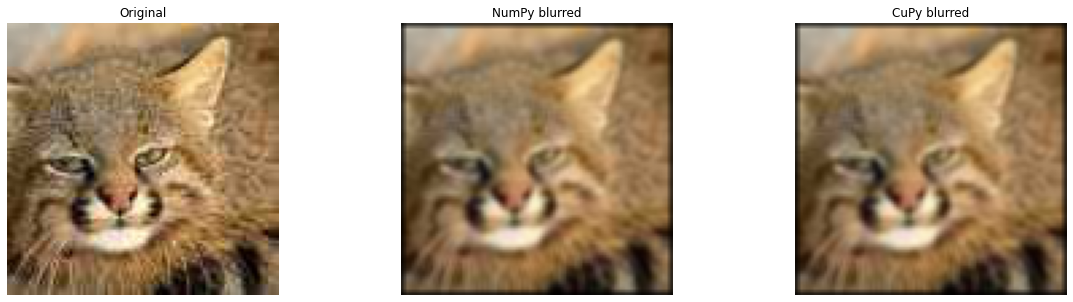

In [98]:
fig, ax = plt.subplots(figsize=(20, 5), ncols=3)

ax[0].imshow(np_img)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(np_blur_img)
ax[1].set_title('NumPy blurred')
ax[1].axis('off')

ax[2].imshow(cp.asnumpy(cp_blur))
ax[2].set_title('CuPy blurred')
ax[2].axis('off')

plt.show()

In [78]:
%timeit -n 10 np.dstack([np_conv(np_img[:, :, i], np_kernel) for i in range(np_img.shape[-1])]).astype(np.uint8)

1.88 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%timeit -n 10 cp.dstack([cp_conv(cp_img[:, :, i], cp_kernel) for i in range(cp_img.shape[-1])])

483 µs ± 251 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


cupy outperforms numpy by a huge margin in time performance as can be seen 